# Imports


In [ ]:
import gc
import glob
import json
import os
import pickle
import random
import shutil
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageDraw, ImageFont
from tqdm import tqdm

import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
import torchvision.transforms as T
from torchvision import transforms
from torchvision.models.detection import FasterRCNN_ResNet50_FPN_Weights
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# from kaggle_secrets import UserSecretsClient

# Global Variables

In [3]:
SCORE_THRES = 0.55 # minimum confidence score prediction should have
IOU_THRES = 0.5 # minimum overlap for bounding boxes to classify as correct pred

TRAIN_DIR = "/kaggle/input/train-patches/patches_with_annotations"
TEST_IMAGES_DIR = "/kaggle/input/test-patches/test_patches_with_annotations/cpg/images"
TEST_ANNS_DIR   = "/kaggle/input/test-patches/test_patches_with_annotations/cpg/annotations"
OUTPUT_VIS_DIR = "detection_visuals_new"

# A: train on pas-original & pas-diagnostic, test on pas-cpg
# B: train on pas-original & pas-diagnostic, finetune on pas-cpg, test on pas-cpg
# C: train on pas-cpg, test on pas-cpg
TRAIN_MODEL = 'A' 

TRAIN_DATASET_FRAC = 0.5 if TRAIN_MODEL == 'A' else 0.7 # modelA = 0.5, modelC = 0.7
TEST_DATASET_FRAC = 0.5

VERBOSE = True

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Trained model locations for later retrieval
modelA_path = "/kaggle/input/modela_og/pytorch/default/1/FasterRCNN_ModelA_0.5.pth"
modelB_path = "/kaggle/input/modelb/pytorch/default/1/FasterRCNN_modelB_0.7.pth"
modelC_path = "/kaggle/input/modelc/pytorch/default/1/FasterRCNN_ModelC_0.7.pth"

# Helper functions

In [4]:
class InflammatoryCellsDataset(Dataset):
    def __init__(self, root_dir, splits, transforms=None): #annotations_dir,
        self.root_dir = Path(root_dir)
        #self.annotations_dir = Path(annotations_dir)
        self.splits = splits
        self.transforms = transforms

        self.image_paths = []
        self.annotation_paths = []

        for split in splits:
            image_dir = self.root_dir / split / "images"
            ann_dir = self.root_dir / split / "annotations"

            for image_path in image_dir.glob("*.png"):
                ann_path = ann_dir / image_path.name.replace(".png", ".json")
                if ann_path.exists():
                    # Load the annotation and check for non-empty bbox list
                    with open(ann_path) as f:
                        ann_data = json.load(f)
                    if not ann_data:  # skip empty annotation files
                        continue
                        
                    self.image_paths.append(image_path)
                    self.annotation_paths.append(ann_path)

        assert len(self.image_paths) == len(self.annotation_paths), "Mismatch in images and annotations"

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load image
        img_path = self.image_paths[idx]
        ann_path = self.annotation_paths[idx]
        image = Image.open(img_path).convert("RGB")

        # Load annotations
        with open(ann_path) as f:
            ann_data = json.load(f)

        boxes = []
        labels = []

        for item in ann_data:
            boxes.append(item["bbox"])
            labels.append(1)  # Binary label: 1 = inflammatory cell

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        target = {
            "boxes": boxes,
            "labels": labels,
            "image_id": torch.tensor([idx])
        }

        if self.transforms:
            image = self.transforms(image)

        return image, target

def collate_fn(batch):
    return tuple(zip(*batch))


def get_transform(train):
    transforms = []
    transforms.append(T.PILToTensor())
    transforms.append(T.ConvertImageDtype(torch.float32))
    if train:
        # add data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)


def get_model(num_classes=2, predownload=False):
    if predownload: # when internet connection not working in Kaggle
        print('loading model with manual weight input')
        # Manually load model without downloading weights
        model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=None, weights_backbone=None)
        
        # Load the weights from the file
        state_dict = torch.load("/kaggle/input/pretrained-fasterrcnn/pytorch/default/1/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth")
        model.load_state_dict(state_dict)
    else:  
        print('loading model with automatic weight input')
        # Load model including downloading weights
        model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT)
        
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
        
    return model

# subsample train, val, and test datasets for given fraction
def subsample_dataset(dataset, fraction):
    indices = torch.randperm(len(dataset))[:int(len(dataset) * fraction)]
    return torch.utils.data.Subset(dataset, indices)

def print_verbose(text):
    if VERBOSE:
        print(text)

def retrieve_trained_model(path, dictionary=False):
    model = get_model(num_classes=2, predownload=True)
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    model.to(device)
    if dictionary:
        # Load the checkpoint
        checkpoint = torch.load(path)
        
        # Restore the model state_dict
        model.load_state_dict(checkpoint['model_state_dict'])
        
        # Restore the training history
        history = checkpoint['history']
    else:
        # model = get_model(num_classes=2, predownload=True)
        # model.to(device)
        model.load_state_dict(torch.load(path))
        history = None

    return model, history

# Training Data preparation

In [8]:
# Prepare combined train splits
train_splits = ['pas cpg'] if TRAIN_MODEL=='C' else ['pas-original', 'pas-diagnostic']
print(f'Creating training data from {train_splits}')
full_train = InflammatoryCellsDataset(TRAIN_DIR, splits=train_splits, transforms=get_transform(True))

# 80/20 train/val split
train_size = int(0.8 * len(full_train))
val_size = len(full_train) - train_size
train_ds, val_ds = random_split(full_train, [train_size, val_size])

Creating training data from ['pas-original', 'pas-diagnostic']


In [9]:
# Take subset of available samples depending on computational resources available
train_ds = subsample_dataset(train_ds, TRAIN_DATASET_FRAC)  
val_ds = subsample_dataset(val_ds, TRAIN_DATASET_FRAC)    

# DataLoaders
train_loader = DataLoader(train_ds, batch_size=4, shuffle=True, collate_fn=collate_fn)
val_loader   = DataLoader(val_ds, batch_size=4, shuffle=False, collate_fn=collate_fn)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = get_model(num_classes=2, predownload=True)
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

loading model with manual weight input


In [10]:
# Save training dataset distribution for future retrieval
training_distribution = {'train' : len(train_ds), 'val' : len(val_ds)}

print_verbose(f"Training on {len(train_ds)} samples (80% split from: {train_splits}")
print_verbose(f"Validating on {len(val_ds)} samples (20% split from: {train_splits})")

Training on 6322 samples (80% split from: ['pas-original', 'pas-diagnostic']
Validating on 1581 samples (20% split from: ['pas-original', 'pas-diagnostic'])


# Model training

In [10]:
def box_iou(boxes1, boxes2):
    """
    Compute IoU between two sets of boxes.
    boxes1, boxes2: [N,4] tensors (xmin, ymin, xmax, ymax)
    Returns IoU matrix [N, M]
    """
    area1 = (boxes1[:, 2] - boxes1[:, 0]).clamp(min=0) * (boxes1[:, 3] - boxes1[:, 1]).clamp(min=0)
    area2 = (boxes2[:, 2] - boxes2[:, 0]).clamp(min=0) * (boxes2[:, 3] - boxes2[:, 1]).clamp(min=0)

    lt = torch.max(boxes1[:, None, :2], boxes2[:, :2])  # [N,M,2]
    rb = torch.min(boxes1[:, None, 2:], boxes2[:, 2:])  # [N,M,2]

    wh = (rb - lt).clamp(min=0)  # [N,M,2]
    inter = wh[:, :, 0] * wh[:, :, 1]  # [N,M]

    union = area1[:, None] + area2 - inter
    iou = inter / union
    return iou

def evaluate_precision_recall(outputs, targets, iou_threshold=IOU_THRES):
    """
    Compute TP, FP, FN for a batch of predictions and targets.
    outputs: list of dicts with keys ['boxes', 'labels', 'scores']
    targets: list of dicts with keys ['boxes', 'labels']
    """

    TP = 0
    FP = 0
    FN = 0

    for preds, targs in zip(outputs, targets):
        pred_boxes = preds['boxes']
        pred_scores = preds['scores']
        pred_labels = preds['labels']

        true_boxes = targs['boxes']
        true_labels = targs['labels']

        if len(pred_boxes) == 0:
            # No predictions, all true boxes are false negatives
            FN += len(true_boxes)
            continue

        if len(true_boxes) == 0:
            # No ground truth, all preds are false positives
            FP += len(pred_boxes)
            continue

        # Filter predictions by score threshold (optional, e.g., 0.5)
        score_thresh = SCORE_THRES   # TWEAKED, WAS 0.5 BEFORE
        keep = pred_scores >= score_thresh
        pred_boxes = pred_boxes[keep]
        pred_labels = pred_labels[keep]

        if len(pred_boxes) == 0:
            FN += len(true_boxes)
            continue

        # Compute IoU matrix between preds and true boxes
        ious = box_iou(pred_boxes, true_boxes)  # [num_pred, num_true]

        # Match preds to true boxes by IoU > threshold and label match
        matched_gt = set()
        matched_pred = set()

        for pred_idx in range(ious.shape[0]):
            for gt_idx in range(ious.shape[1]):
                if ious[pred_idx, gt_idx] >= iou_threshold and pred_labels[pred_idx] == true_labels[gt_idx]:
                    if gt_idx not in matched_gt and pred_idx not in matched_pred:
                        matched_gt.add(gt_idx)
                        matched_pred.add(pred_idx)

        TP += len(matched_pred)
        FP += len(pred_boxes) - len(matched_pred)
        FN += len(true_boxes) - len(matched_gt)

    precision = TP / (TP + FP) if (TP + FP) > 0 else 0.0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0.0
    
    return precision, recall

In [12]:
def train_model(model, optimizer, train_loader, val_loader, device, num_epochs=10, lr_scheduler=None):
    model.to(device)

    # Record training history
    history = {
        "train_loss": [],
        "val_precision": [],
        "val_recall": []
    }

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch + 1}/{num_epochs}")
        print("-" * 20)

        # ---------- Training ----------
        model.train()
        total_train_loss = 0.0

        for images, targets in tqdm(train_loader, desc="Training"):
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            loss_dict = model(images, targets)
            total_loss = sum(loss for loss in loss_dict.values())

            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()

            total_train_loss += total_loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        history["train_loss"].append(avg_train_loss)

        if lr_scheduler:
            lr_scheduler.step()

        # ---------- Validation ----------
        model.eval()
        total_val_loss = 0.0                # <— new
        val_precision = 0.0
        val_recall = 0.0
        num_batches = 0

        with torch.no_grad():
            for images, targets in tqdm(val_loader, desc="Validation"):
                images = [img.to(device) for img in images]
                targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

                # compute loss on validation:
                # loss_dict = model(images, targets)
                # val_loss = sum(loss for loss in loss_dict.values())
                # total_val_loss += val_loss.item()

                # compute precision/recall via inference
                outputs = model(images)
                precision, recall = evaluate_precision_recall(outputs, targets)
                val_precision += precision
                val_recall += recall

                num_batches += 1

        # Average metrics
        #avg_val_loss = total_val_loss / len(val_loader)    
        avg_precision = val_precision / num_batches
        avg_recall = val_recall / num_batches

        # Record
        #history["val_loss"].append(avg_val_loss)           
        history["val_precision"].append(avg_precision)
        history["val_recall"].append(avg_recall)

        print(f"Train Loss: {avg_train_loss:.4f} | Precision: {avg_precision:.4f} | Recall: {avg_recall:.4f}")

    return model, history


In [ ]:
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

model, history = train_model(
    model=model,
    optimizer=optimizer,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    num_epochs=10,
    lr_scheduler=lr_scheduler
)

In [15]:
torch.save({
    'model_state_dict': model.state_dict(),
    'history': history,
    'training_distribution' : training_distribution
}, "FasterRCNN_ModelA_frac0.5.pth")  # CHANGE NAME ACCORDINGLY '.._Modelx_fracy.pth'

## Save Model automatically to permanent location

In [2]:
# user_secrets = UserSecretsClient()
# secret_value_0 = user_secrets.get_secret("luukneervens")

# # Create config directory
# os.makedirs("/root/.config/kaggle", exist_ok=True)

# # Copy kaggle.json instead of moving
# shutil.copy("/kaggle/input/kagglekey/kaggle.json", "/root/.config/kaggle/kaggle.json")

# # Set permissions
# os.chmod("/root/.config/kaggle/kaggle.json", 0o600)

# print("✅ Kaggle API token is configured.")

# # Define where to save
# dataset_name = "inflammatory-cell-detector"
# username = "luukneervens"  # ← change this to your actual Kaggle username!
# output_dir = "saved_model"
# os.makedirs(output_dir, exist_ok=True)

# # 1. Save the model
# model_path = os.path.join(output_dir, "FasterRCNN_1.pth")
# torch.save(model.state_dict(), model_path)
# print(f"Model saved to: {model_path}")

# # 2. Create the metadata file (required by Kaggle CLI)
# metadata = {
#     "title": dataset_name,
#     "id": f"{username}/{dataset_name}",
#     "licenses": [{"name": "CC0-1.0"}]
# }

# with open(os.path.join(output_dir, "dataset-metadata.json"), "w") as f:
#     json.dump(metadata, f)

# # 3. Upload the dataset using the Kaggle CLI
# # NOTE: This only works if you have your Kaggle API token configured in the notebook environment
# !kaggle datasets create -p saved_model -u

In [3]:
# # Setup Kaggle API token from input dataset (uploaded file)
# os.makedirs("/root/.config/kaggle", exist_ok=True)
# shutil.copy("/kaggle/input/kagglekey/kaggle.json", "/root/.config/kaggle/kaggle.json")
# os.chmod("/root/.config/kaggle/kaggle.json", 0o600)
# print("✅ Kaggle API token configured.")

# # Save your model + training history together
# output_dir = "saved_model"
# os.makedirs(output_dir, exist_ok=True)
# model_path = os.path.join(output_dir, "FasterRCNN_ModelC_0.7.pth")

# torch.save({
#     'model_state_dict': model.state_dict(),
#     'history': history,
#     'training_distribution' : training_distribution
# }, model_path)

# print(f"Model + history saved to: {model_path}")

# # Create metadata file for Kaggle dataset
# dataset_name = "AIMI-project"
# username = "luukneervens"

# metadata = {
#     "title": dataset_name,
#     "id": f"{username}/{dataset_name}",
#     "licenses": [{"name": "CC0-1.0"}]
# }

# with open(os.path.join(output_dir, "dataset-metadata.json"), "w") as f:
#     json.dump(metadata, f)

# # Upload or update dataset on Kaggle
# !kaggle datasets create -p saved_model -u


# Model Eval

In [6]:
def iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    interW = max(0, xB - xA)
    interH = max(0, yB - yA)
    interArea = interW * interH
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    unionArea = boxAArea + boxBArea - interArea
    return interArea / unionArea if unionArea > 0 else 0

# ---------------------------
# Image → Tensor transform
# ---------------------------
to_tensor = transforms.ToTensor()


def visualize_and_save(img: Image.Image, gt_boxes, pred_boxes, out_path: str,
                       pred_scores=None,
                       gt_color=(0,255,0), pred_color=(255,0,0), 
                       thickness=2):
    """
    Draws gt_boxes and pred_boxes onto img and saves to out_path.
    gt_boxes, pred_boxes: lists of [xmin,ymin,xmax,ymax]
    pred_scores: list of scores (same length as pred_boxes)
    """
    os.makedirs(os.path.dirname(out_path), exist_ok=True)
    draw = ImageDraw.Draw(img)

    # Optional: load a default font for labels
    try:
        font = ImageFont.load_default()
    except:
        font = None

    # Draw GT boxes
    for box in gt_boxes:
        draw.rectangle(box, outline=gt_color, width=thickness)
        if font:
            draw.text((box[0], box[1]-10), "GT", fill=gt_color, font=font)

    # Draw Predicted boxes
    for i, box in enumerate(pred_boxes):
        draw.rectangle(box, outline=pred_color, width=thickness)
        if font:
            score_str = f"PRED: {pred_scores[i]:.2f}" if pred_scores else "PRED" # add pred score
            draw.text((box[0], box[3]+2), score_str, fill=pred_color, font=font)

    img.save(out_path)


def evaluate_on_patches(model, TEST_IMAGES_DIR, TEST_ANNS_DIR, OUTPUT_VIS_DIR, 
                        iou_threshold=IOU_THRES, score_thresh=SCORE_THRES, 
                        device="cuda", fraction=0.5, generate_imgs=True):
    model.to(device).eval()
    
    TP = FP = FN = 0
    image_paths = glob.glob(os.path.join(Path(TEST_IMAGES_DIR), "*.png"))
    print(f"Found {len(image_paths)} patches, testing on random subset of {int(fraction*len(image_paths))} patches")

    print(f'score threshold: {score_thresh}, IoU threshold: {iou_threshold}.')

    # take random subset of all test patches
    random.seed(42) # to ensure reproducibility
    random.shuffle(image_paths)
    image_paths = image_paths[:int(len(image_paths) * fraction)]

    with torch.no_grad():
        for img_path in tqdm(image_paths):
            patient_id = '_'.join(Path(img_path).stem.split('_')[:2])
            #print(f'processing image: {patient_id}...')

            # 1) Load and preprocess
            img = Image.open(img_path).convert("RGB")
            img_t = to_tensor(img).to(device)            # C×H×W tensor in [0,1]
            preds = model([img_t])[0]                   # dict with 'boxes', 'scores', 'labels'

            # 2) Filter out low‐confidence preds
            keep = preds["scores"] > score_thresh
            pred_boxes = preds["boxes"][keep].cpu().tolist()
            pred_scores = preds["scores"][keep].cpu().tolist()


            # 3) Load GT boxes
            stem = Path(img_path).stem
            ann_path = Path(TEST_ANNS_DIR) / f"{stem}.json"
            with open(ann_path, 'r') as f:
                gt_data = json.load(f)
            if isinstance(gt_data, dict) and "annotations" in gt_data:
                gt_boxes = [ann["bbox"] for ann in gt_data["annotations"]]
            else:
                gt_boxes = [ann["bbox"] for ann in gt_data]

            # 4) Match preds → GT
            matched_gt = set()
            for pb in pred_boxes:
                best_iou, best_j = 0, -1
                for j, gb in enumerate(gt_boxes):
                    if j in matched_gt: 
                        continue
                    score = iou(pb, gb)
                    if score > best_iou:
                        best_iou, best_j = score, j

                if best_iou >= iou_threshold:
                    TP += 1
                    matched_gt.add(best_j)
                else:
                    FP += 1

            # 5) Any unmatched GT → FN
            FN += (len(gt_boxes) - len(matched_gt))

            if generate_imgs:
                out_file = os.path.join(OUTPUT_VIS_DIR, f"{stem}_vis.png")
                visualize_and_save(
                    img.copy(),
                    gt_boxes,
                    pred_boxes,
                    out_file,
                    pred_scores=preds["scores"][keep].cpu().tolist()
                )



    # 6) Compute metrics
    precision = TP / (TP + FP) if TP + FP > 0 else 0.0
    recall    = TP / (TP + FN) if TP + FN > 0 else 0.0
    f1_score  = 2 * (precision * recall) / (precision + recall) \
                    if (precision + recall) else 0.0

    print(f"--- Evaluation over {len(image_paths)} patches ---")
    print(f"TP: {TP}, FP: {FP}, FN: {FN}")
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}")
    print(f"F1 Score : {f1_score:.4f}")

    return {"TP": TP, "FP": FP, "FN": FN, "precision": precision, "recall": recall, "f1": f1_score}

In [ ]:
# Retrieve previously trained model
model_path = "/kaggle/input/modelc/pytorch/default/1/FasterRCNN_ModelC_0.7.pth"
model, history = retrieve_trained_model(model_path, dictionary=True)

In [ ]:
# Run evaluation
metrics = evaluate_on_patches(
    model,
    TEST_IMAGES_DIR,
    TEST_ANNS_DIR,
    OUTPUT_VIS_DIR,
    device=device, 
    fraction=0.5
)

In [5]:
# # Zip test detection output images for download
# shutil.make_archive("detection_visuals_new", 'zip', "detection_visuals_new")

# Model B
load model A and finetune on pas-cpg

In [ ]:
# Load full PAS-CpG dataset
cpg_patches_train = InflammatoryCellsDataset(
    root_dir=TRAIN_DIR,             
    splits=['pas-cpg'],  # use 'train' split of CpG
    transforms=get_transform(True)
)

train_size = int(0.8 * len(cpg_patches_train))
val_size = len(cpg_patches_train) - train_size
train_ds, val_ds = random_split(cpg_patches_train, [train_size, val_size])

# Take subset of available samples depending on computational resources available
frac = 0.7
train_ds = subsample_dataset(train_ds, frac)  
val_ds = subsample_dataset(val_ds, frac)    

# DataLoaders
train_loader = DataLoader(
    train_ds, 
    batch_size=4, 
    shuffle=True, 
    collate_fn=collate_fn,  
    num_workers=0,        
)
val_loader = DataLoader(
    val_ds, 
    batch_size=4, 
    shuffle=False, 
    collate_fn=collate_fn,     
    num_workers=0,             
)
# Load model A
modelA_path = "/kaggle/input/modela_og/pytorch/default/1/FasterRCNN_ModelA_0.5.pth"
modelA, history = retrieve_trained_model(modelA_path)

params = [p for p in modelA.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.0001, momentum=0.9, weight_decay=0.0005) # smaller lr so model doesn't unlearn low level features

training_distribution = {'train' : len(train_ds), 'val' : len(val_ds)}
print_verbose(f"Training on {len(train_ds)} samples (80% split from: pas-cpg)")
print_verbose(f"Validating on {len(val_ds)} samples (20% split from: pas-cpg)")

loading model with manual weight input
Training on 6248 samples (80% split from: pas-cpg)
Validating on 1562 samples (20% split from: pas-cpg)


In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# Training loop: fine-tune on 5 epochs
modelB, historyB = train_model(
    model=modelA,
    optimizer=optimizer,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    num_epochs=5,  # less epochs for finetuning
    lr_scheduler=lr_scheduler
)

In [35]:
torch.save({
    'model_state_dict': modelB.state_dict(),
    'history': historyB,
    'training_distribution': training_distribution
}, "FasterRCNN_modelB_0.7.pth")

In [ ]:
# Run evaluation
metrics = evaluate_on_patches(
    modelB,
    TEST_IMAGES_DIR,
    TEST_ANNS_DIR,
    OUTPUT_VIS_DIR,
    device=device, 
    fraction=0.5,
    generate_imgs=False
)

# Plot training loss and FROC

In [ ]:
modelA, historyA = retrieve_trained_model(modelA_path, dictionary=False)
modelB, historyB = retrieve_trained_model(modelB_path, dictionary=True)
modelC, historyC = retrieve_trained_model(modelC_path, dictionary=True)

## Training loss

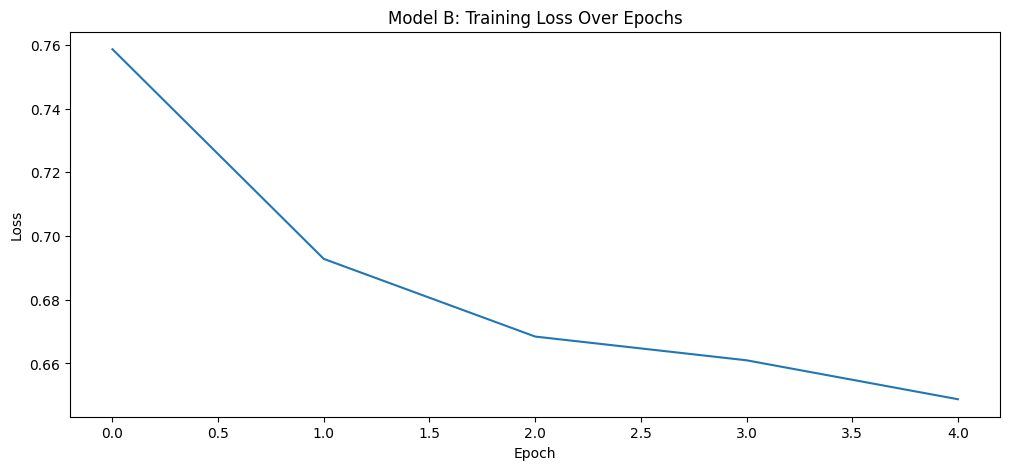

In [19]:
# plot training history
plt.figure(figsize=(12, 5))
plt.plot(historyB['train_loss'], label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model B: Training Loss Over Epochs')
#plt.savefig('modelB_loss')
plt.show()

## FROC

In [ ]:
score_thresholds = [round(s, 2) for s in np.arange(0.0, 1.01, 0.1)]
results = []
nr_eval_samples = 2025

for thresh in score_thresholds:
    res = evaluate_on_patches(
        modelC,
        TEST_IMAGES_DIR, 
        TEST_ANNS_DIR, 
        OUTPUT_VIS_DIR,
        score_thresh=thresh, 
        device=device, 
        fraction=0.5,
        generate_imgs=False  # Don't generate images with pred and GT for FROC computation
    )
    results.append({
        'threshold': thresh,
        'TP': res['TP'],
        'FP': res['FP'],
        'FN': res['FN'],
        'precision': res['precision'],
        'recall': res['recall'],
        'f1': res['f1'],
        'sensitivity': res['recall'],
        'fp_per_image': res['FP'] / nr_eval_samples
    })
    torch.cuda.empty_cache()
    gc.collect()

In [ ]:
# Save
# with open("FROC_modelC.pkl", "wb") as f:
#     pickle.dump(results, f)

# Load later
# with open("my_dict.pkl", "rb") as f:
#     loaded_dict = pickle.load(f)

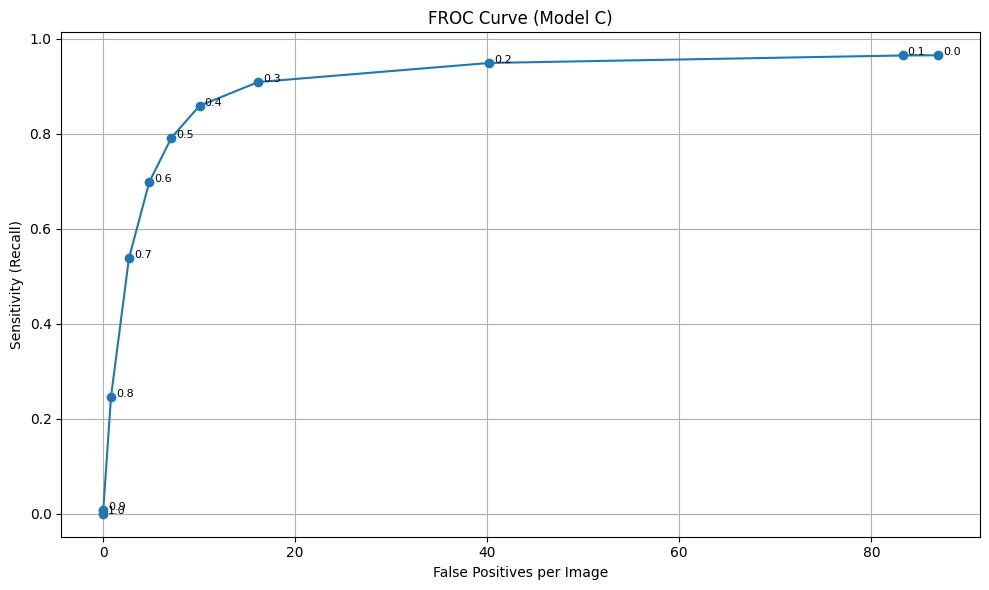

In [38]:
sensitivities = [r['sensitivity'] for r in results]
fps_per_image = [r['fp_per_image'] for r in results]
thresholds = [r['threshold'] for r in results]

plt.figure(figsize=(10, 6))
plt.plot(fps_per_image, sensitivities, marker='o')

# Annotate each point with its corresponding threshold
for x, y, t in zip(fps_per_image, sensitivities, thresholds):
    plt.text(x + 0.5, y, f"{t:.1f}", fontsize=8)

plt.xlabel('False Positives per Image')
plt.ylabel('Sensitivity (Recall)')
plt.title('FROC Curve (Model C)')
plt.grid(True)
plt.tight_layout()
plt.savefig('FROC_ModelC.png')  # Ensure proper extension
plt.show()